# Figure 5: Obsering Performance Degradation as the Index-Size Grows

This analysis shows the performance degradation for ingest rates as the index grows on an m3.tiny instance.
We include our measurements and the code to generate the figures.

### Prerequisites

To recreate the figure only the dependencies along with the datasets in "../data/figure5" are required.

Ensure the following imports work:

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

Specify data path (default is measurements series used in the paper):

In [42]:
DATA_DIR = "../data/figure5/2022-08-22T22:20:58.760324_m3.quad_heartily-thorough-llama"

To repeat the measurements prepare random datasets with 100.000 entries each and take the time it takes for the following query to complete:

    client.execute('INSERT INTO nsdf.catalog (catalog, bucket, name, size, last_modified, etag) VALUES', list(entries))
    
To monitor the resulting disk utilization shutil was used before and after each INSERT-query.

    import shutil
    shutil.disk_usage(storage_path_to_monitor)
    
The storage path to monitor when using Clickhouse as a backend is typically "/var/lib/clickhouse".

## Loading and Preparing the Data

In [44]:
df_ingest = pd.read_csv(f"{DATA_DIR}/ingest_measurements.csv")
df_ingest.head()

,Unnamed: 0,iteration,elapsed,num_inserts,type,ops/sec,disk_total,disk_free,disk_used,disk_free -h,disk_percent_free,disk_percent_used,index_size_before
0,0,0,0.665131,100000,ingest,150346.217194,20617822208,8722362368,11878682624,8.1 GiB,0.423050,0.576137,9000000
1,1,1,0.674334,100000,ingest,148294.513955,20617822208,8683728896,11917316096,8.1 GiB,0.421176,0.578010,9100000
2,2,2,0.570133,100000,ingest,175397.673752,20617822208,8666656768,11934388224,8.1 GiB,0.420348,0.578838,9200000
3,3,3,0.641891,100000,ingest,155789.646949,20617822208,8649506816,11951538176,8.1 GiB,0.419516,0.579670,9300000
4,4,4,0.650083,100000,ingest,153826.489851,20617822208,8632434688,11968610304,8.0 GiB,0.418688,0.580498,9400000


In [40]:
nbins = 25

df_ingest["index_size_bin"] = pd.cut(df_ingest["index_size_before"], bins=nbins)
df_ingest["elapsed_bin"] = pd.cut(df_ingest["elapsed"], bins=nbins)
df_ingest["ops/sec_bin"] = pd.cut(df_ingest["ops/sec"], bins=nbins)

## Generating Figure 5

[Text(58.222222222222214, 0.5, 'Ingest Rate: Entries/s'),
 Text(0.5, 36.72222222222221, 'Index Size (Million Entries)')]

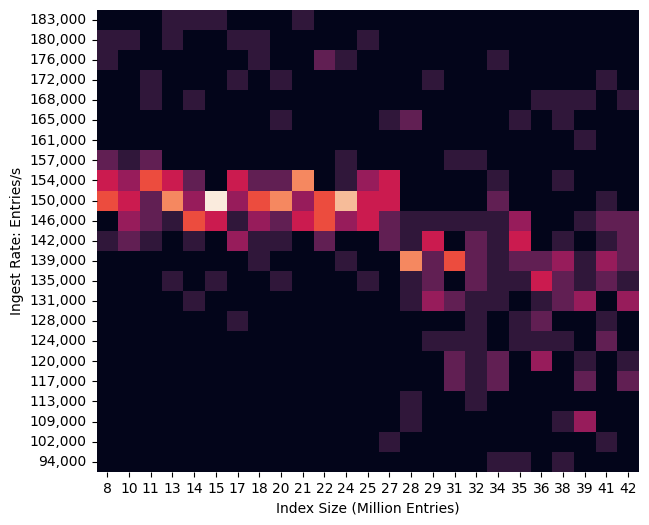

In [41]:
import seaborn as sns
import humanize
from matplotlib import rcParams



df = df_ingest

yfieldname = "ops/sec_bin"
ct = pd.crosstab(df[yfieldname], df["index_size_bin"])
ct = ct.sort_values(yfieldname, ascending=False)

def custom_round(x, base=1000):
    return int(base * round(float(x)/base))


xticklabels = pd.Series(ct.columns.values).apply(lambda x:  int(x.left/1000000) )
yticklabels = pd.Series(ct.index.values).apply(lambda x: humanize.intcomma(custom_round(((x.left +  x.right)/2))) )

rcParams['figure.figsize'] = 7, 6

ax = sns.heatmap(
    ct, 
    xticklabels=xticklabels,
    yticklabels=yticklabels,
    cbar=False
)

ax.set(
    ylabel='Ingest Rate: Entries/s', 
    xlabel='Index Size (Million Entries)'
)